# 导入包和函数

In [31]:
import os
import sys
import time
import json
import warnings
from itertools import product
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from scipy.interpolate import BSpline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm

# 设置随机种子
torch.manual_seed(756)
np.random.seed(756)


# 获取当前 Notebook 所在文件夹的绝对路径
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# 测试导入
from mfdnn import *
from utils import *

# 基础设置

In [32]:
# 设置随机种子
torch.manual_seed(756)
np.random.seed(756)

# 数据路径
data_path = "/Users/wangdongxue/Documents/MFDNN/MFDNN/RunTimeAnalysis"

Ts = [32, 64, 128]
Ps = [10, 50, 100]
n = 200
# 配置参数
configurations = [
    {'T': T, 'p': p}
    for T in Ts
    for p in Ps
]

# 超参数网格
lam1_values = [0.5, 1, 1.5, 2, 2.5, 3]
lam2_values = [0, 0.001, 0.01, 0.1, 0.5, 1]

# 模型参数
model_params = {
    'num_basis': (5, 5),
    'layer_sizes': [64, 64],
    'epochs': 100,
    'val_ratio': 0.2,
    'patience': 10
}

# 真实显著变量定义
true_vars = {0, 1}

# 阈值ε
epsilon = 0.01

# 辅助函数

In [ ]:
def calculate_selection_metrics(l21_norms, true_vars, epsilon=0.01, p=6):
    """计算变量选择指标 - 只关注F1和完美选择"""
    selected_vars = set(i for i, norm in enumerate(l21_norms) if norm > epsilon)
    
    # 计算基础指标
    true_positive = len(selected_vars & true_vars)
    false_positive = len(selected_vars - true_vars)
    false_negative = len(true_vars - selected_vars)
    
    # 只计算F1分数
    f1_score = (2 * true_positive) / (2 * true_positive + false_positive + false_negative) if (2 * true_positive + false_positive + false_negative) > 0 else 0
    
    # 完美选择指标
    perfect_selection = 1.0 if selected_vars == true_vars else 0.0
    
    return f1_score, perfect_selection, selected_vars

def select_best_hyperparameters(X_train, y_train, true_vars, p, domain_range, lam1_values, lam2_values, model_params, epsilon=0.01):
    """选择最佳超参数 - 修正版本"""
    mse_results = np.zeros((len(lam1_values), len(lam2_values)))
    f1_results = np.zeros((len(lam1_values), len(lam2_values)))
    selection_info = {}
    
    # 计算训练集的标准化参数
    y_train_mean = np.mean(y_train)
    y_train_std = np.std(y_train)
    
    for i, lam1 in enumerate(lam1_values):
        for j, lam2 in enumerate(lam2_values):
            try:
                train_losses, val_losses, model, l21 = MFDNN(
                    p=p, resp=y_train, func_cov=X_train,
                    num_basis=model_params['num_basis'],
                    layer_sizes=model_params['layer_sizes'],
                    domain_range=domain_range,
                    epochs=model_params['epochs'],
                    val_ratio=model_params['val_ratio'],
                    patience=model_params['patience'],
                    lam1=lam1, lam2=lam2, std_resp=True
                )
                
                # MSE指标
                mse_results[i, j] = min(val_losses) if len(val_losses) > 0 else np.mean(train_losses[-10:])
                
                # 变量选择指标
                f1_score, perfect_selection, selected_vars = calculate_selection_metrics(l21, true_vars, epsilon, p)
                f1_results[i, j] = f1_score
                
                # 存储选择信息
                selection_info[f"{i}_{j}"] = {
                    'model': model, 'lam1': lam1, 'lam2': lam2,
                    'f1_score': f1_score, 'mse': mse_results[i, j],
                    'selected_vars': list(selected_vars),
                    'y_mean': y_train_mean, 'y_std': y_train_std,
                    'perfect_selection': perfect_selection
                }
            
                
            except Exception as e:
                mse_results[i, j] = np.inf
                f1_results[i, j] = 0
    
    # 选择最佳超参数
    best_f1 = np.max(f1_results)
    best_f1_indices = np.where(f1_results == best_f1)
    
    if len(best_f1_indices[0]) > 0:
        
        best_candidates = [selection_info[f"{i}_{j}"] for i, j in zip(best_f1_indices[0], best_f1_indices[1])]
        best_candidate = min(best_candidates, key=lambda x: x['mse'])
    else:
        # 如果没有找到任何有效的F1分数，使用固定默认值
        default_lam1 = 1
        default_lam2 = 0.1
        print("使用默认超参数: lam1=1, lam2=0.1")
        
        # 创建一个默认的候选者
        best_candidate = {
            'model': None, 'lam1': default_lam1, 'lam2': default_lam2,
            'f1_score': 0, 'mse': np.inf, 'selected_vars': [],
            'y_mean': y_train_mean, 'y_std': y_train_std, 'perfect_selection': 0
        }
    
    return best_candidate['lam1'], best_candidate['lam2'], best_candidate


def evaluate_on_test_set(best_candidate, X_test, y_test, p, domain_range, model_params):
    """在测试集上评估性能 - 返回多个指标和预测值"""
    try:
        # 获取标准化参数
        y_mean = best_candidate['y_mean']
        y_std = best_candidate['y_std']
        
        # 使用MFDNN预测（返回标准化后的预测值）
        test_predictions_normalized = MFDNN_predict(p, best_candidate['model'], X_test, model_params['num_basis'], domain_range)
 
        # 将预测值反标准化到原始尺度
        test_predictions_original = test_predictions_normalized.detach().numpy() * y_std + y_mean
        
        # 计算测试集MSE（在原始尺度上）
        test_mse = np.mean((test_predictions_original.flatten() - y_test) ** 2)
        
        # 计算RMSE
        test_rmse = np.sqrt(test_mse)
            
        return test_rmse, best_candidate['f1_score']
    except Exception as e:
        return np.inf, best_candidate['f1_score']


# 运行时间

In [42]:
# 存储结果
results_summary = {}

for T in Ts:
    for p in Ps:
        start_time = time.time()
        print(f"\n{'='*50}")
        print(f"Processing T={T}, p={p}")
        print(f"{'='*50}")

        # 载入数据，只取一次
        X_array = np.load(os.path.join(data_path, f"Xlist_T{T}_p{100}.npy"), allow_pickle=True)[0]
        y_array = np.load(os.path.join(data_path, f"ylist_T{T}_p{100}.npy"), allow_pickle=True)[0]

        # 截取前 p 个变量
        X_array = X_array[:p, :, :, :]
        p_actual, N, T1, T2 = X_array.shape

        # 拆分训练/测试集
        split_idx = N // 2
        X_train = X_array[:, :split_idx, :, :]
        X_test = X_array[:, split_idx:, :, :]

        y_full = y_array  # 只处理单个 y
        y_train = y_full[:split_idx]
        y_test = y_full[split_idx:]

        # 选择最佳超参数
        lam1, lam2, best_candidate = select_best_hyperparameters(
            X_train, y_train, true_vars, p_actual,
            domain_range=[[[0, 0], [1, 1]]] * p_actual,
            lam1_values=lam1_values,
            lam2_values=lam2_values,
            model_params=model_params,
            epsilon=epsilon
        )

        # 测试集评估
        test_rmse, test_f1 = evaluate_on_test_set(
            best_candidate, X_test, y_test, p_actual,
            domain_range=[[[0, 0], [1, 1]]] * p_actual,
            model_params=model_params
        )

        # 保存结果，包括 RMSE
        selected_vars = set(best_candidate['selected_vars'])
        elapsed_time = time.time() - start_time

        results_summary[f"T{T}_p{p}"] = {
            'test_rmse': test_rmse,   # 新增 RMSE 记录
            'test_f1': test_f1,
            'selected_vars': selected_vars,
            'run_time_sec': elapsed_time
        }

        print(f"Done T={T}, p={p}, time={elapsed_time:.2f}s")
        print(f"  RMSE={test_rmse:.4f}, F1={test_f1:.4f}, selected_vars={selected_vars}")


Processing T=32, p=10
[[0.10559405 0.10300232 0.10725059 0.10681728 0.10757282 0.10905747]
 [0.10987423 0.10851319 0.10378194 0.10753534 0.10932393 0.11161537]
 [0.113538   0.11412442 0.11349944 0.11376411 0.11643638 0.11665644]
 [0.13069622 0.11934952 0.12875655 0.1254214  0.1242499  0.12438659]
 [0.13981645 0.1336454  0.13328725 0.13225207 0.13054368 0.1354917 ]
 [0.14617997 0.14320086 0.14563707 0.13933077 0.14578369 0.147387  ]]
Done T=32, p=10, time=3.77s
  RMSE=0.0190, F1=1.0000, selected_vars={0, 1}

Processing T=32, p=50
[[0.11825228 0.12098156 0.12310185 0.12434211 0.10404489 0.11657661]
 [0.12297417 0.11968825 0.12495811 0.11848837 0.10781882 0.12813686]
 [0.14257886 0.12937066 0.13881984 0.13281831 0.13908277 0.14510238]
 [0.1513679  0.15155737 0.12531415 0.14233902 0.14729644 0.91911381]
 [0.15308598 0.14222987 0.9334985  0.93448335 0.91913605 0.95656079]
 [0.94981635 0.16891864 0.93792498 0.15511987 0.17607351 0.933119  ]]
Done T=32, p=50, time=12.82s
  RMSE=0.0201, F1=1.

# 保存结果

In [45]:
import pandas as pd
import os

# 保存路径
save_path = os.path.join(data_path, "RunTime_mfdnn.csv")

# 转换 results_summary 为 DataFrame
df_results = pd.DataFrame([
    {
        "T": int(key.split("_")[0].replace("T", "")),
        "p": int(key.split("_")[1].replace("p", "")),
        "test_rmse": value["test_rmse"],               # 新增 RMSE
        "test_f1": value["test_f1"],
        "selected_vars": ",".join(map(str, sorted(value["selected_vars"]))),
        "run_time_sec": value["run_time_sec"]
    }
    for key, value in results_summary.items()
])

# 按 T, p 数值排序
df_results = df_results.sort_values(by=["T", "p"], ascending=[True, True]).reset_index(drop=True)

# 保存为 CSV
df_results.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"\n✅ Results saved to: {save_path}")
print(df_results)


✅ Results saved to: /Users/wangdongxue/Documents/MFDNN/MFDNN/RunTimeAnalysis/RunTime_mfdnn.csv
     T    p  test_rmse  test_f1 selected_vars  run_time_sec
0   32   10   0.018961      1.0           0,1      3.770136
1   32   50   0.020120      1.0           0,1     12.821460
2   32  100   0.020719      1.0           0,1     24.314047
3   64   10   0.011068      1.0           0,1     12.713834
4   64   50   0.011786      1.0           0,1     58.636939
5   64  100   0.012707      1.0           0,1    110.480604
6  128   10   0.005704      1.0           0,1     40.897044
7  128   50   0.006030      1.0           0,1    192.179579
8  128  100   0.005955      1.0           0,1    382.274898


# 画图

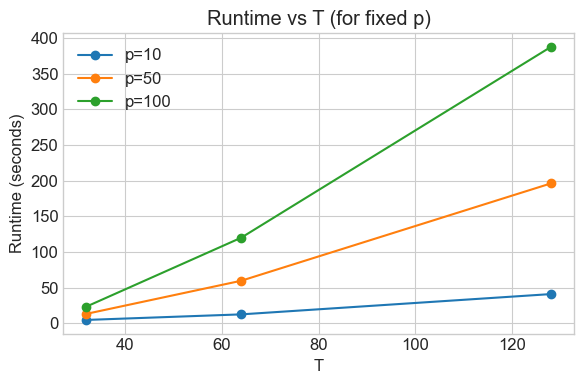

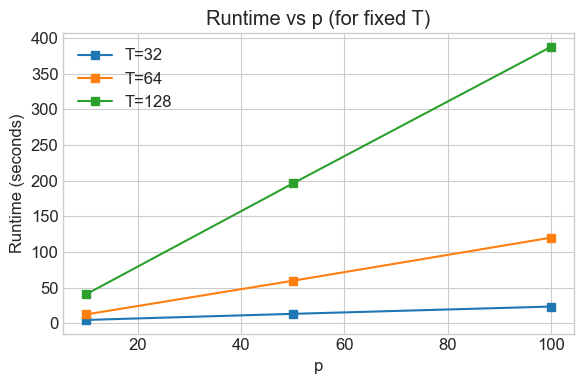

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# === 读取结果文件 ===
data_path = "/Users/wangdongxue/Documents/MFDNN/MFDNN/RunTimeAnalysis"
csv_file = os.path.join(data_path, "RunTime_mfdnn.csv")
df = pd.read_csv(csv_file)

# === 绘图风格设置 ===
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (6, 4)

# -------------------------------------
# 1️⃣ 固定 p，查看 run_time 随 T 变化
# -------------------------------------
plt.figure()
for p_val in sorted(df['p'].unique()):
    subset = df[df['p'] == p_val].sort_values('T')
    plt.plot(subset['T'], subset['run_time_sec'], marker='o', label=f"p={p_val}")

plt.xlabel("T")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime vs T (for fixed p)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(data_path, "runtime_vs_T.png"), dpi=300)
plt.show()

# -------------------------------------
# 2️⃣ 固定 T，查看 run_time 随 p 变化
# -------------------------------------
plt.figure()
for T_val in sorted(df['T'].unique()):
    subset = df[df['T'] == T_val].sort_values('p')
    plt.plot(subset['p'], subset['run_time_sec'], marker='s', label=f"T={T_val}")

plt.xlabel("p")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime vs p (for fixed T)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(data_path, "runtime_vs_p.png"), dpi=300)
plt.show()

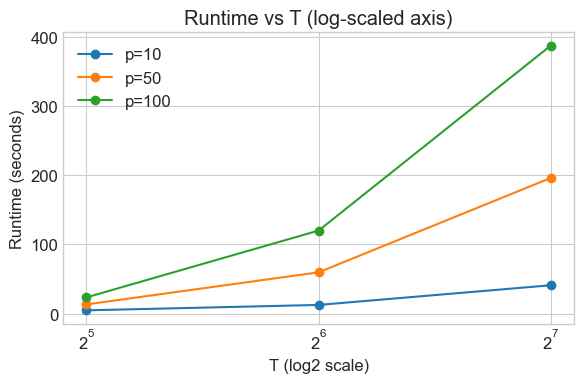

In [40]:
plt.figure()
for p_val in sorted(df['p'].unique()):
    subset = df[df['p'] == p_val].sort_values('T')
    plt.plot(subset['T'], subset['run_time_sec'], marker='o', label=f"p={p_val}")

plt.xscale('log', base=2)   # ⭐ 对横轴取 log2，让 32→64→128 等距显示
plt.xlabel("T (log2 scale)")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime vs T (log-scaled axis)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(data_path, "runtime_vs_T_logscale.png"), dpi=300)
plt.show()